# Introduction to Catboost

In this tutorial we would explore some base cases of using catboost, such as model training, cross-validation and predicting, as well as some useful features like early stopping,  snapshot support, feature importances and parameters tuning.


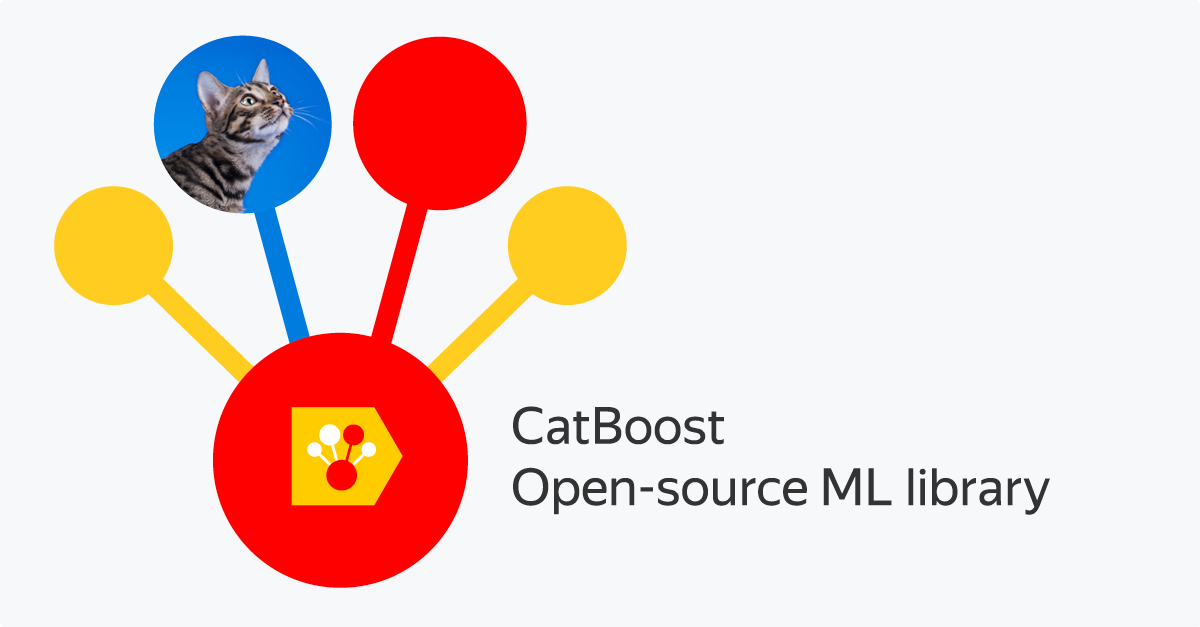

## $$Contents$$
* [1. Data Preparation](#$$1.\-Data\-Preparation$$)
    * [1.1 Data Loading](#1.1-Data-Loading)
    * [1.2 Feature Preparation](#1.2-Feature-Preparation)
    * [1.3 Data Splitting](#1.3-Data-Splitting)
* [2. CatBoost Basics](#$$2.\-CatBoost\-Basics$$)
    * [2.1 Model Training](#2.1-Model-Training)
    * [2.2 Model Cross-Validation](#2.2-Model-Cross-Validation)
    * [2.3 Model Applying](#2.3-Model-Applying)
* [3. CatBoost Features](#$$3.\-CatBoost\-Features$$)
    * [3.1 Using the best model](#3.1-Using-the-best-model)
    * [3.2 Early Stopping](#3.2-Early-Stopping)
    * [3.3 Using Baseline](#3.3-Using-Baseline)
    * [3.4 Snapshot Support](#3.4-Snapshot-Support)
    * [3.5 User Defined Objective Function](#3.5-User-Defined-Objective-Function)
    * [3.6 User Defined Metric Function](#3.6-User-Defined-Metric-Function)
    * [3.7 Staged Predict](#3.7-Staged-Predict)
    * [3.8 Feature Importances](#3.8-Feature-Importances)
    * [3.9 Eval Metrics](#3.9-Eval-Metrics)
    * [3.10 Learning Processes Comparison](#3.10-Learning-Processes-Comparison)
    * [3.11 Model Saving](#3.11-Model-Saving)
* [4. Parameters Tuning](#$$4.\-Parameters\-Tuning$$)

## $$1.\ Data\ Preparation$$
### 1.1 CatBoost installation
If you have not already installed CatBoost, you can do so by running '!pip install catboost' command.  
  
Also you should install ipywidgets package and run special command before launching jupyter notebook to draw plots.

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

### 1.2 Data Loading
The data for this tutorial can be obtained from the legendary [Titanic ML competition](https://www.kaggle.com/c/titanic/overview) – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to use machine learning to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [ ]:
from catboost.datasets import titanic
import numpy as np

train_df, test_df = titanic()

train_df.head()

### 1.3 Feature Preparation
First of all let's check how many absent values do we have:

In [ ]:
null_value_stats = train_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

As we cat see, **`Age`**, **`Cabin`** and **`Embarked`** indeed have some missing values, so let's fill them with some number way out of their distributions - so the model would be able to easily distinguish between them and take it into account:

In [ ]:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

Now let's separate features and label variable:

In [ ]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

Pay attention that our features are of differnt types - some of them are numeric, some are categorical, and some are even just strings, which normally should be handled in some specific way (for example encoded with bag-of-words representation). But in our case we could treat these string features just as categorical one - all the heavy lifting is done inside CatBoost. How cool is that? :)

In [ ]:
print(X.dtypes)

categorical_features_indices = np.where(X.dtypes != np.float)[0]

### 1.4 Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = test_df

## $$2.\ CatBoost\ Basics$$

In [ ]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

### 2.1 Model Training
Now let's create the model itself: We would go here with default parameters (they provide a _really_ good baseline), the only thing we would like to specify here is `custom_loss` parameter, as this would give us an ability to see what's going on in terms of this competition metric - accuracy, as well as to be able to watch for logloss, as it would be more smooth on dataset of such size.

In [ ]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    verbose=100,
    plot=True
);

As you can see, it is possible to watch our model learn through verbose output or with nice plots (personally I would definately go with the second option - just check out those plots: you can, for example, zoom in areas of interest!)

With this we can see that the best accuracy value of **0.8340** (on validation set) was acheived on **157** boosting step.

### 2.2 Model Cross-Validation

It is good to validate your model, but to cross-validate it - even better. And also with plots! So with no more words:

In [ ]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

Now we have values of our loss functions at each boosting step averaged by 3 folds, which should provide us with a more accurate estimation of our model performance:

In [ ]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

In [ ]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

As we can see, our initial estimation of performance on single validation fold was too optimistic - that is why cross-validation is so important!

### 2.3 Model Applying

In [ ]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(predictions[:10])
print(predictions_probs[:10])

## $$3.\ CatBoost\ Features$$
You may have noticed that on model creation step I've specified not only `custom_loss` but also `random_seed` parameter. That was done in order to make this notebook reproducible - by default catboost chooses some random value for seed:

In [ ]:
model_without_seed = CatBoostClassifier(iterations=10, logging_level='Silent')
model_without_seed.fit(X, y, cat_features=categorical_features_indices)

print('Random seed assigned for this model: {}'.format(model_without_seed.random_seed_))

In [ ]:
# Define custom parameters for the model
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}

# Pool stores all information about dataset (features, labels, categorical features, weights, etc.)
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

### 3.1 Using the best model
If you essentially have a validation set, it's always better to use the `use_best_model` parameter during training. By default, this parameter is enabled. If it is enabled, the resulting trees ensemble is shrinking to the best iteration.

In [ ]:
# Create the model with the specified custom parameters
model = CatBoostClassifier(**params)

# Train the model using the Pool object
model.fit(train_pool, eval_set=validate_pool)

# Add 'use_best_model' parameter
best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})

# Create the best model using custom parameters with additional 'use_best_model' parameter
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

# Compare the accuracy
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, best_model.predict(X_validation))
))

### 3.2 Early Stopping
If you essentially have a validation set, it's always easier and better to use early stopping. This feature is similar to the previous one, but only in addition to improving the quality it still saves time.

In [ ]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

In [ ]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

In [ ]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

# Better quality in a shorter time
print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Though as was shown earlier simple validation scheme does not precisely describes model out-of-train score (may be biased because of dataset split) it is still nice to track model improvement dynamics - and thereby as we can see from this example it is really good to stop boosting process earlier (before the overfitting kicks in)

### 3.3 Using Baseline

In [ ]:
current_params = params.copy()
current_params.update({
    'iterations': 200
})

model = CatBoostClassifier(**current_params).fit(X_train, y_train, categorical_features_indices)

# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')

# Fit new model using pre-training results (baseline) for training
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline);

### 3.4 Snapshot Support

In [ ]:
# We can use snapshots for recovering training after an interruption or 
# for starting training with previous results

params_with_snapshot = params.copy()
params_with_snapshot.update({
    'iterations': 5,
    'learning_rate': 0.5,
    'logging_level': 'Verbose'
})

model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)
params_with_snapshot.update({
    'iterations': 10,
    'learning_rate': 0.1,
})

model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)

### 3.5 User Defined Objective Function

In [ ]:
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers which have only __len__ and __getitem__ defined).
        # weights parameter can be None.
        #
        # To understand what these parameters mean, assume that there is
        # a subset of your dataset that is currently being processed.
        # approxes contains current predictions for this subset,
        # targets contains target values you provided with the dataset.
        #
        # This function should return a list of pairs (der1, der2), where
        # der1 is the first derivative of the loss function with respect
        # to the predicted value, and der2 is the second derivative.
        #
        # In our case, logloss is defined by the following formula:
        # target * log(sigmoid(approx)) + (1 - target) * (1 - sigmoid(approx))
        # where sigmoid(x) = 1 / (1 + e^(-x)).
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            der1 = (1 - p) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [ ]:
model = CatBoostClassifier(
    iterations=10,
    random_seed=42, 
    loss_function=LoglossObjective(), 
    eval_metric="Logloss"
)

# Fit model
model.fit(train_pool)

# Only prediction_type='RawFormulaVal' is allowed with custom `loss_function`
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

### 3.6 User Defined Metric Function

In [ ]:
class LoglossMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is float.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += -w * (target[i] * approx[i] - np.log(1 + np.exp(approx[i])))

        return error_sum, weight_sum

In [ ]:
model = CatBoostClassifier(
    iterations=10,
    random_seed=42, 
    loss_function="Logloss",
    eval_metric=LoglossMetric()
)

# Fit model
model.fit(train_pool)

# Only prediction_type='RawFormulaVal' is allowed with custom `loss_function`
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

### 3.7 Staged Predict
CatBoost model has `staged_predict` method. It allows you to iteratively get predictions for a given range of trees.

In [ ]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)

ntree_start, ntree_end, eval_period = 3, 9, 2

predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)

for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

### 3.8 Feature Importances

In [ ]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)

# Sometimes it is important to understand which feature made the greatest contribution
feature_importances = model.get_feature_importance(train_pool)

feature_names = X_train.columns

# Higher score means higher contribution
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

### 3.9 Eval Metrics

In [ ]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)

# `eval_metrics` allows you to calculate a given metrics on a given dataset
eval_metrics = model.eval_metrics(validate_pool, ['AUC'], plot=True)

In [ ]:
print(eval_metrics['AUC'][:6])

### 3.10 Learning Processes Comparison

In [ ]:
from catboost import MetricVisualizer

# Compare different models learning process on a single plot
model1 = CatBoostClassifier(iterations=10, depth=1, train_dir='model_depth_1/', logging_level='Silent')
model1.fit(train_pool, eval_set=validate_pool)

model2 = CatBoostClassifier(iterations=10, depth=5, train_dir='model_depth_5/', logging_level='Silent')
model2.fit(train_pool, eval_set=validate_pool)

widget = MetricVisualizer(['model_depth_1', 'model_depth_5'])
widget.start()

### 3.11 Model Saving

In [ ]:
# It is always handy to be able to dump your model to disk (especially if training took some time)
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')

model = CatBoostClassifier()
model.load_model('catboost_model.dump');

# 4. Parameters Tuning
While you could always select optimal number of iterations (boosting steps) by cross-validation and learning curve plots, it is also important to play with some of model parameters, and we would like to pay some special attention to `l2_leaf_reg` and `learning_rate`.

In [ ]:
# We'll select the parameters using the hyperopt package.
!pip install hyperopt

In [ ]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [ ]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(42)
)

print(best)

Now let's get all cv data with best parameters:

In [ ]:
model = CatBoostClassifier(
#     l2_leaf_reg=int(best['l2_leaf_reg']),
#     learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=10,
    loss_function='Logloss',
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [ ]:
# Default parameters = 0.8283
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

# 5. Create Submission

In [ ]:
import pandas as pd

# Re-train our tuned model on all training data
model.fit(X, y, cat_features=categorical_features_indices)

# Create submission file
submisstion = pd.DataFrame()
submisstion['PassengerId'] = X_test['PassengerId']
submisstion['Survived'] = model.predict(X_test)
submisstion.to_csv('submission.csv', index=False)